In [199]:
from requests import get
import datetime as dt
import random
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import resource
import sys

Below a list of user agents to rotate between, when sending out requests to scrape the data about the TDF starters:

In [200]:
user_agent_list = [
   #Chrome
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (Windows NT 5.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
    #Firefox
    'Mozilla/4.0 (compatible; MSIE 9.0; Windows NT 6.1)',
    'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (Windows NT 6.2; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.0; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)',
    'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/6.0)',
    'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; .NET CLR 2.0.50727; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729)'
]

In [201]:
#List with all the riders 
Rider_Names = []

The following function scrapes different features of a rider and returns a dataframe with the data. The features are for example Name, Weight, Height, Birthday, Results, Teams, etc.

In [209]:
def get_rider_info(rider_name,i):
  user_agent = rider_name
  RiderUrl = 'https://www.procyclingstats.com/rider/%s/' % rider_name
  headers = {'User-Agent': user_agent[i]}
  RiderResponse = get(RiderUrl, headers=headers)
  html_soup = BeautifulSoup(RiderResponse.text, 'html.parser')
  #Get rider name
  RiderName = html_soup.find_all("title")[0].contents[0]
  
  #Get rider weight
  RiderWeight = []
  try:
    RiderWeight = float(html_soup.find('b', text='Weight:').next_sibling.strip()[:-3])
  except AttributeError:
    RiderWeight = np.nan
  else:
    RiderWeight = float(html_soup.find('b', text='Weight:').next_sibling.strip()[:-3])
  
  #Get rider height
  RiderHeight = []
  try:
    RiderHeight = float(html_soup.find('b', text='Height:').next_sibling.strip()[:-2])
  except AttributeError:
    RiderHeight = np.nan
  else:
    RiderHeight = float(html_soup.find('b', text='Height:').next_sibling.strip()[:-2])
  
  #Get rider Birthday
    #Get rider Birthday
  RiderBirthMonthYear = html_soup.find('meta', attrs={'name': 'description'})['content']
  res = re.search("\(born\s([0-9]{4}\-[0-9]{2}\-[0-9]{2})\)", RiderBirthMonthYear).group(1)
  RiderBirthdate = dt.datetime.strptime(res,'%Y-%m-%d')

  #Get retirement date
  rt = []
  for ultag in html_soup.find_all('ul', {'class': 'moblist rdr-teams'}):
    for litag in ultag.find_all('li'):
        if "Retired" in litag.text:
            rt.append(litag.text)
  try:
    dt.datetime.strptime(''.join(rt).strip()[-10:], '%Y-%m-%d')
  except ValueError:
    RiderRetirementDate = pd.NaT
  else:
    RiderRetirementDate = dt.datetime.strptime(''.join(rt).strip()[-10:], '%Y-%m-%d')

  #Get Rider Nationality
  RiderNationality = html_soup.find('a', {'class': 'black'}).text.strip()

  #Get Rider Starts
  keyStartsList = html_soup.find('ul', {'class': 'key-stats'}).find('li')

  RiderGTStarts = int(re.search(r'\d+', keyStartsList.text).group(0))
  RiderClassicsStarts = int(re.search(r'\d+', keyStartsList.next_sibling.text).group(0))

  #Get Rider KeyStats
  RiderKeyStatsUrl = RiderUrl + '/statistics/key-career-stats'

  KeyStatsResponse = get(RiderKeyStatsUrl, headers=headers)
  
  KeyStats_soup = BeautifulSoup(KeyStatsResponse.text, 'html.parser')
  
  OneDayStats = []
  try:
    OneDayStats = float(KeyStats_soup.find('h3', text = "1. One-day-races").next_sibling.text.strip('%'))/100
  except ValueError:
    OneDayStats = float(0)
  else:
    OneDayStats = float(KeyStats_soup.find('h3', text = "1. One-day-races").next_sibling.text.strip('%'))/100

  GCStats = []
  try:
    GCStats = float(KeyStats_soup.find('h3', text = "2. General classifications").next_sibling.text.strip('%'))/100
  except ValueError:
    GCStats = float(0)
  else:
    GCStats = float(KeyStats_soup.find('h3', text = "2. General classifications").next_sibling.text.strip('%'))/100

  StagesStats = []
  try:
    StagesStats = float(KeyStats_soup.find('h3', text = "3. Stages").next_sibling.text.strip('%'))/100
  except ValueError:
    StagesStats = float(0)
  else:
    StagesStats = float(KeyStats_soup.find('h3', text = "3. Stages").next_sibling.text.strip('%'))/100
    
  TTStats = []
  try:
    TTStats = float(KeyStats_soup.find('h3', text = "4. Time trial").next_sibling.text.strip('%'))/100
  except ValueError:
    TTStats = float(0)
  else:
    TTStats = float(KeyStats_soup.find('h3', text = "4. Time trial").next_sibling.text.strip('%'))/100

    
  #Create a dataframe to store all the information
  Data = {'Name':[RiderName], 'Weight':[RiderWeight], 'Height':[RiderHeight], 'Birthdate':[RiderBirthdate],'RetirementDate':[RiderRetirementDate],
         'Nationality':[RiderNationality], 'StartsGT':[RiderGTStarts], 'StartsClassics':[RiderClassicsStarts], 'StatsOneday':[OneDayStats],
         'StatsGC':[GCStats], 'StatsStages':[StagesStats], 'StatsTT':[TTStats], }
  RiderInfo = pd.DataFrame(Data)  
 
  #Get rider team per year
  team = []
  team_year = []
  for ultag in html_soup.find_all('ul', {'class': 'moblist rdr-teams'}):
    for litag in ultag.find_all('li'):
        if re.match('^\d{4}', litag.text):
            team.append(litag.text[4:])
            team_year.append(litag.text[:4])

  RiderInfo['Team'] = [team]
  RiderInfo['Team Year'] = [team_year]

  #Get rider season statistics
  RiderSeasonStatsUrl = RiderUrl + '/statistics/season-statistics'
  
  SeasonStatsResponse = get(RiderSeasonStatsUrl, headers=headers)
  
  SeasonStats_soup = BeautifulSoup(SeasonStatsResponse.text, 'html.parser')
  SeasonStats_table = SeasonStats_soup.select('tbody tr')
  
  l = []
  for tr in SeasonStats_table:
    td = tr.find_all('td')
    row = [tr.text for tr in td if tr.text]
    if row:
        l.append(row)
        
  RiderSeasonStatistics = pd.DataFrame(l, columns=["Season", "Points", "Racedays", "KMs", "Wins", "Top-10s"])
  RiderSeasonStatistics.drop(RiderSeasonStatistics.tail(1).index,inplace=True)

#Create array for RiderInfo dataframe
  RiderInfo['Stats Season'] = [RiderSeasonStatistics['Season'].to_numpy()]
  RiderInfo['Stats Points'] = [RiderSeasonStatistics['Points'].to_numpy()]
  RiderInfo['Stats Racedays'] = [RiderSeasonStatistics['Racedays'].to_numpy()]
  RiderInfo['Stats KMs'] = [RiderSeasonStatistics['KMs'].to_numpy()]
  RiderInfo['Stats Wins'] = [RiderSeasonStatistics['Wins'].to_numpy()]
  RiderInfo['Stats Top-10s'] = [RiderSeasonStatistics['Top-10s'].to_numpy()]


  
  #Get rider Grand Tour statistics
  RiderGTStatsUrl = RiderUrl + 'statistics/grand-tour-starts'
  GTStatsResponse = get(RiderGTStatsUrl, headers=headers)
  
  GTStats_soup = BeautifulSoup(GTStatsResponse.text, 'html.parser')
  data = []
  GTStats_table = GTStats_soup.find('table', attrs={'class':'basic'})
  table_header = GTStats_table.find('thead')
  table_body = GTStats_table.find('tbody')
  rows = table_body.find_all('tr')
  all_cols = []
  column_names = table_header.find_all('th')
  for col in column_names:
        col_1 = col.text.strip()
        all_cols.append(col_1)

  for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append(cols) # Get rid of empty values
  GTStats_df = pd.DataFrame(data, columns = all_cols).drop('#', axis=1)
  GTStats_df['DNF']=np.where(GTStats_df['GC'] == 'DNF',1,0)
  GTStats_df['GC']=np.where(GTStats_df['GC'] == 'DNF',np.nan,GTStats_df['GC'])
  GTStats_df['GC'] = pd.to_numeric(GTStats_df['GC'])
  GTStats_df['GC10']=np.where(GTStats_df['GC'] <= 10,1,0)
  GTStats_df['GC25']=np.where(GTStats_df['GC'] <= 25,1,0)
  GTStats_df['GC150']=np.where(GTStats_df['GC'] <= 150,1,0)
  GTStats_df['Season'] = pd.to_numeric(GTStats_df['Season'])
  GTStats_df['Best stage result']=np.where(GTStats_df['Best stage result'] == '?',100,GTStats_df['Best stage result'])
  GTStats_df['Best stage result'] = pd.to_numeric(GTStats_df['Best stage result'])
  GTStats_df['Best stage result']= np.where((GTStats_df['Best stage result'] >= 250) | (np.isnan(GTStats_df['Best stage result'])),
                                            100,GTStats_df['Best stage result'])
  GTStats_df = GTStats_df.drop(['GC', 'Points', 'Mountains', 'Youth'], axis=1)
  GTStats_grouped = GTStats_df.groupby('Season').agg(best_result=('Best stage result', 'min'),
                                                      DNF=('DNF', 'sum'),
                                                      GC10=('GC10', 'sum'),
                                                      GC25=('GC25', 'sum'),
                                                      GC150=('GC150', 'sum'),
                                                    starts_GT=('Season','count')).reset_index().sort_values('Season',
                                                                                                           ascending=False)


#Create array for RiderInfo dataframe
  RiderInfo['Season GT'] = [GTStats_grouped['Season'].to_numpy()]
  RiderInfo['Starts GT'] = [GTStats_grouped['starts_GT'].to_numpy()]
  RiderInfo['Stage GT'] = [GTStats_grouped['best_result'].to_numpy()]
  RiderInfo['DNF GT'] = [GTStats_grouped['DNF'].to_numpy()]
  RiderInfo['GC10 GT'] = [GTStats_grouped['GC10'].to_numpy()]
  RiderInfo['GC25 GT'] = [GTStats_grouped['GC25'].to_numpy()]
  RiderInfo['GC150 GT'] = [GTStats_grouped['GC150'].to_numpy()]
  return RiderInfo

In order to obtain the Tour de France starter lists, the years to be scraped are stored in a list:

In [205]:
#Get rider names
#List with years of TdF startlists
Years = list(range(1995, 2020))
RidersTDF = []

Next, all TdF starters for the given years are scraped from the crawled startlists

In [206]:
for i in range(len(Years)):
    TdfURL = 'https://www.procyclingstats.com/race/tour-de-france/'+str(Years[i])+'/gc/startlist'
    headers = {'User-Agent': user_agent_list[random.randint(1,(len(user_agent_list))-1)]}
    TdfResponse = get(TdfURL, headers=headers)
    Tdf_soup = BeautifulSoup(TdfResponse.text, 'html.parser')
    
    for ahref in Tdf_soup.find_all('a', {'class': 'rider blue'}):
        RidersTDF.append(ahref['href'][6:])

This results in 1358 riders for the years 1995 till 2019:

In [207]:
RidersTDF = list(set(RidersTDF))
len(RidersTDF)

1358

In [210]:
#Scraping the data for the list of riders:

rider_names = RidersTDF
RidersInfo = None

for rider_name in rider_names:
  RiderInfo = get_rider_info(rider_name,0)
  if RidersInfo is None:
    RidersInfo = RiderInfo
  else:
    RidersInfo = RidersInfo.append(RiderInfo, ignore_index = True)

Raw scraped data:

In [253]:
RidersInfo.head(2)

,Name,Weight,Height,Birthdate,RetirementDate,Nationality,StartsGT,StartsClassics,StatsOneday,StatsGC,...,Stats Wins,Stats Top-10s,Season GT,Starts GT,Stage GT,DNF GT,GC10 GT,GC25 GT,GC150 GT,ID
0,Denis Leproux,NaN,NaN,1964-12-16,NaT,France,1,0,0.42,0.78,...,"[1, 0, 0, 0, 1, 0, 0, 1]","[1, 1, 2, 2, 1, 0, 3, 2]",[1998],[1],[34],[0],[0],[0],[1],0
1,Trent Lowe,NaN,NaN,1984-10-08,NaT,Australia,1,1,0.02,0.82,...,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 6, 4, 1, 4]",[2008],[1],[34],[0],[0],[0],[1],1


## In this part of the notebook the raw data is being cleaned, transformed and additional features engineered:

In [1534]:
import matplotlib as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from ast import literal_eval

In [1630]:
RawData = RidersInfo

In [1631]:
#Creation of an ID to identify each rider across seasons
RawData['ID'] = np.arange(len(RawData))

In [1632]:
RawData.head(1)

,Name,Weight,Height,Birthdate,RetirementDate,Nationality,StartsGT,StartsClassics,StatsOneday,StatsGC,...,Stats Wins,Stats Top-10s,Season GT,Starts GT,Stage GT,DNF GT,GC10 GT,GC25 GT,GC150 GT,ID
0,Denis Leproux,NaN,NaN,1964-12-16,NaT,France,1,0,0.42,0.78,...,"[1, 0, 0, 0, 1, 0, 0, 1]","[1, 1, 2, 2, 1, 0, 3, 2]",[1998],[1],[34],[0],[0],[0],[1],0


The following function is used to cover the nested arrays into the long format (1 row = 1 season):

In [1633]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [1634]:
col_season= ['Stats Season', 'Stats KMs', 'Stats Points', 'Stats Wins', 'Stats Racedays', 'Stats Top-10s']
col_GT = ['Season GT', 'Starts GT', 'Stage GT', 'DNF GT',
       'GC10 GT', 'GC25 GT', 'GC150 GT']

Split the data set in two parts: 1. the data scraped from the main page of a rider and 2. the statistics scraped from subpages.  
This is done, as the number of entries is not equal between the two, as some riders had seasons without being part of a professional cycling team:

In [1635]:
TeamRaw = explode(RawData, ['Team', 'Team Year'], fill_value=np.nan).drop(col_season + col_GT, 1)


In [1636]:
#Season Statistics:
StatsRaw = explode(RawData, col_season, fill_value=np.nan)[['ID'] + col_season]
#set data types right for StatsRaw
cols=[i for i in StatsRaw.columns]
for col in cols:
    StatsRaw[col]=pd.to_numeric(StatsRaw[col])
StatsRaw.head()

,ID,Stats Season,Stats KMs,Stats Points,Stats Wins,Stats Racedays,Stats Top-10s
0,0,2000,2423,25,1,17,1
1,0,1999,785,1,0,4,1
2,0,1998,4944,35,0,30,2
3,0,1997,0,95,0,2,2
4,0,1992,0,100,1,1,1


In [1637]:
#GrandTour Statistics
GTRaw = explode(RawData, col_GT, fill_value=np.nan)[['ID'] + col_GT]
#set data types right for GTRaw
cols=[i for i in GTRaw.columns]
for col in cols:
    GTRaw[col]=pd.to_numeric(GTRaw[col])
GTRaw.head()

,ID,Season GT,Starts GT,Stage GT,DNF GT,GC10 GT,GC25 GT,GC150 GT
0,0,1998,1,34,0,0,0,1
1,1,2008,1,34,0,0,0,1
2,2,2019,1,42,1,0,0,0
3,2,2018,2,1,0,0,0,2
4,2,2017,2,5,0,0,0,2


In [1638]:
StatsRaw = pd.merge(StatsRaw, GTRaw,
                    how='left', left_on=['ID', 'Stats Season'],
                    right_on=['ID', 'Season GT']).drop('Season GT', axis=1).fillna(int(0))


Unfortunately the scraped data is not without errors and outliers. Some riders got results from before they were even alive, while others decided in their late 50s to start racing again.  
Below the seasons affected with errors or outliers are removed:

In [1639]:
def drop_a_season(Rider, Season_y):
    rider_ID = TeamRaw[TeamRaw['Name'] == Rider]['ID'].unique()[0]
    df_drop = StatsRaw[(StatsRaw['ID'] == rider_ID) & (StatsRaw['Stats Season'] == Season_y)]
    return StatsRaw.drop(df_drop.index)



#drop wrong data: Maryan Hary - Season 1906
StatsRaw = drop_a_season('Maryan Hary', 1906)

#drop wrong data: Francisco Pérez - Season 1970
StatsRaw = drop_a_season('Francisco Pérez', 1970)
#FP_ID = TeamRaw[TeamRaw['Name'] == 'Francisco Pérez']['ID'].unique()[0]
#StatsRaw = StatsRaw[((StatsRaw['ID'] != FP_ID) & (StatsRaw['Stats Season'] != 1970))]

#drop wrong data: Aitor Garmendia - Season 1977
StatsRaw = drop_a_season('Aitor Garmendia', 1977)
#AG_ID = TeamRaw[TeamRaw['Name'] == 'Aitor Garmendia']['ID'].unique()[0]
#StatsRaw = StatsRaw[((StatsRaw['ID'] != AG_ID) & (StatsRaw['Stats Season'] != 1977))]

#drop wrong data: Gian Matteo Fagnini - Season 1983
StatsRaw = drop_a_season('Gian Matteo Fagnini', 1983)
#GM_ID = TeamRaw[TeamRaw['Name'] == 'Gian Matteo Fagnini']['ID'].unique()[0]
#StatsRaw = StatsRaw[((StatsRaw['ID'] != GM_ID) & (StatsRaw['Stats Season'] != 1983))]

#drop wrong data: Laurent Roux - Season 1986
StatsRaw = drop_a_season('Laurent Roux', 1986)

#drop wrong data: Frédéric Guesdon - Season 1985
StatsRaw = drop_a_season('Frédéric Guesdon', 1985)

#drop wrong data: Peter Meinert-Nielsen - Everything after Season 2000
rider_ID = TeamRaw[TeamRaw['Name'] == 'Peter Meinert-Nielsen']['ID'].unique()[0]
df_drop = StatsRaw[(StatsRaw['ID'] == rider_ID) & (StatsRaw['Stats Season'] > 2000)]
StatsRaw = StatsRaw.drop(df_drop.index, axis=0)

#drop wrong data: Andrea Tafi - Everything after Season 2003
rider_ID = TeamRaw[TeamRaw['Name'] == 'Andrea Tafi']['ID'].unique()[0]
df_drop = StatsRaw[(StatsRaw['ID'] == rider_ID) & (StatsRaw['Stats Season'] > 2003)]
StatsRaw = StatsRaw.drop(df_drop.index, axis=0)

Based on the team category a cumulative count of the years riding for a team on a certain level and being a tainee or not feature arre ceated.  
In addition duplicates due to mid-season transfers are deleted (in this case the team with the longest duration is taken as the team for the entire season) 

In [1640]:
YearNow = dt.datetime.now().year #get current year
TeamRaw['Team Year'] = pd.to_numeric(TeamRaw['Team Year'], errors='coerce').fillna(0).astype(np.int64) #convert to int
TeamRaw = TeamRaw[TeamRaw['Team Year'] < int(YearNow)] #filter out all rows with contract longer than current year

In [1641]:
TeamRaw['TeamCat'] = TeamRaw['Team'].str.extract('\((\w+)\).*?', expand=True) #extract team category

In [1642]:
TeamRaw['Team'].value_counts() #check frequency of team strings

AG2R La Mondiale (WT)                         203
Team Katusha  (WT)                            179
Team Telekom (TT1)                            178
Movistar Team (WT)                            169
Banesto (TT1)                                 168
                                             ... 
Mercatone Uno () (Untill 07/05)                 1
Team Hervis Apo Sport (TT3)                     1
Kelme - Costa Blanca (TT1) (As from 22/06)      1
Miche-Guerciotti  (CT) (As from 03/05)          1
Alexia Alluminio () (Untill 01/07)              1
Name: Team, Length: 1768, dtype: int64

In [1643]:
TeamRaw['TeamCatForm'] = TeamRaw['TeamCat'].replace({'TT1':'WT', 'PT':'WT', 'TT2':'PCT', 'TT3':'CT', 'CLUB': np.nan, }) #new column formatted team cat



In [1644]:
TeamRaw['UntilDate'] = TeamRaw['Team'].str.extract('\(Untill\s(\d{2}\/\d{2})\)', expand=True) #date string of 'until xx/xx'
TeamRaw['AsFromDate'] = TeamRaw['Team'].str.extract('\(As\sfrom\s(\d{2}\/\d{2})\)', expand=True) #date string of As from 'xx/xx'
TeamRaw['TraineeDate'] = TeamRaw['Team'].str.extract('\(Trainee as\sfrom\s(\d{2}\/\d{2})\)', expand=True) #date string of 'Trainee as from xx/xx'

TeamRaw['Trainee'] = np.where(TeamRaw['TraineeDate'].isnull(), 0, 1) #making a new column trainee yes = 1; no = 0

TeamRaw['UntilDate'] = TeamRaw['UntilDate']+"/"+TeamRaw['Team Year'].astype(str) #make string for until date
TeamRaw['UntilDate'] = pd.to_datetime(TeamRaw['UntilDate']) #convert until date to datetime

TeamRaw['AsFromDate'] = TeamRaw['AsFromDate']+"/"+TeamRaw['Team Year'].astype(str) #make string for asfrom date
TeamRaw['AsFromDate'] = pd.to_datetime(TeamRaw['AsFromDate']) #convert asfrom date to datetime

In [1645]:
#check for duplicates years + rider id 
grouped = TeamRaw.groupby(['ID', 'Team Year']).size().reset_index(name='count').sort_values('count', ascending = False)
grouped[grouped['count'] > 1]


#filter out any duplicates only due to changing team names
df_droplog = pd.DataFrame()
filteredDf = TeamRaw.loc[(pd.isnull(TeamRaw['AsFromDate'])) &
            (pd.isnull(TeamRaw['UntilDate'])) &
            (TeamRaw['Trainee'] == 0)]
mask = filteredDf.drop_duplicates(subset=['ID', 'Team Year'])
droplog = filteredDf[~filteredDf.isin(mask)].dropna(how='all')
TeamRaw = TeamRaw[~TeamRaw.isin(droplog)].dropna(how='all')

#set TraineeYear=1 for all years where rider is trainee and filter out rows with Trainee=1
TeamRaw['TraineeYear'] = TeamRaw.groupby(['ID', 'Team Year'])['Trainee'].transform(max)
TeamRaw = TeamRaw.loc[(TeamRaw['Trainee'] == 0)]

EndOfSeason = pd.to_datetime("31-12-"+TeamRaw['Team Year'].astype(int).astype(str))
StartOfSeason = pd.to_datetime("01-01-"+TeamRaw['Team Year'].astype(int).astype(str))

#Calculate main team of a season if multiple teams
TeamRaw['TeamLength'] = np.where((pd.notna(TeamRaw['UntilDate']) & (pd.notna(TeamRaw['AsFromDate']))), TeamRaw['UntilDate'] - TeamRaw['AsFromDate'],
                                 np.where(pd.notna(TeamRaw['UntilDate']), TeamRaw['UntilDate'] - StartOfSeason,
                                 np.where(pd.notna(TeamRaw['AsFromDate']), EndOfSeason - TeamRaw['AsFromDate'], np.nan)))


In [1646]:
#sort values, so that duplicates with least TeamLength are dropped
TeamRaw = TeamRaw.sort_values(['ID', 'Team Year', 'TeamLength'])
TeamRaw = TeamRaw.drop_duplicates(subset=['ID', 'Team Year'], keep = 'last') #drop duplicates


In [1647]:
#add retirement date for riders without a retirement date but no contract for 2018
TeamRaw['RetirementDate'] = np.where((TeamRaw.groupby(['ID'])['Team Year'].transform(max) <  2018) & (pd.isna(TeamRaw.groupby(['ID'])['RetirementDate'].transform(max))),
         pd.to_datetime("31-12-"+TeamRaw.groupby(['ID'])['Team Year'].transform(max).astype(int).astype(str)), TeamRaw['RetirementDate'])

In [1648]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(TeamRaw['TeamCatForm'])

# Drop column B as it is now encoded
TeamRaw = TeamRaw.drop('TeamCatForm',axis = 1)
# Join the encoded df
TeamRaw = TeamRaw.join(one_hot)

In [1649]:
TeamRaw = TeamRaw.sort_values(['ID', 'Team Year']) #sort ascending first ID then year to make cumulative sum

TeamRaw['CT'] = TeamRaw.groupby('ID')['CT'].cumsum().astype(int) #cumyears CT
TeamRaw['PCT'] = TeamRaw.groupby('ID')['PCT'].cumsum().astype(int) #cumyears PCT
TeamRaw['WT'] = TeamRaw.groupby('ID')['WT'].cumsum().astype(int) #cumyears WT

In case a rider had a long-term injury or other reasons to have a year without races, these years are added and filled later on with `0` to not have any breaks in the sequences:

In [1650]:

def make_years_ids(df):
    df_year = []
    df_ids = []
    for ids in df['ID'].unique():
        min_Season = df[df['ID'] == ids]['Stats Season'].min()
        max_Season = df[df['ID'] == ids]['Stats Season'].max()
        years = list(range(min_Season, max_Season+1))
        IDs = [ids] * len(years)
        df_year.extend(years)
        df_ids.extend(IDs)
    d = {'Season':df_year,'IDs':df_ids}
    return pd.DataFrame(d)
    
    

In [1651]:
years_ids = make_years_ids(StatsRaw)

Stats_nbreak = pd.merge(years_ids, StatsRaw, how='left',
                        left_on=['IDs', 'Season'],
                        right_on=['ID', 'Stats Season'])

Stats_nbreak.loc[:, Stats_nbreak.columns.difference(['Birthday'])] = Stats_nbreak.loc[:, Stats_nbreak.columns.difference(['Birthday'])].fillna(0)


In the next step, the splitted data is merged together:

In [1652]:
#drop not used columns
TeamRaw = TeamRaw.drop(['TeamLength', 'Trainee', 'TraineeDate', 'UntilDate', 'AsFromDate'], axis = 1)

TeamRaw['ID'] = TeamRaw['ID'].astype(int)
TeamRaw['Team Year'] = TeamRaw['Team Year'].astype(int)

#Merge Team and Stats
Merged = pd.merge(Stats_nbreak, TeamRaw, how='left', right_on=['ID', 'Team Year'], left_on=['IDs', 'Season'])


Finally, to the merged data features such as age or length of career and the target variable `UntilEvent` are created and added to the merged data:  

In [1653]:
# Calculate Careerlength
Merged['CareerLength'] = Merged['Season'] - (Merged.groupby(['IDs'])['Season'].transform(min) - 1)



#start and stop
Merged['start'] = np.where(Merged['CareerLength'] == 1, 0, Merged['CareerLength'].shift())
Merged['stop'] = Merged['Season'] - Merged.groupby(['IDs'])['Season'].transform(min) + 1

Merged['CareerLength'] = Merged['CareerLength'].astype(int)
Merged['start'] = Merged['start'].astype(int)
Merged['stop'] =Merged['stop'].astype(int)


In [1654]:
#Create Age variable
Merged['Birthdate'] = Merged['Birthdate'].fillna(pd.to_datetime("31-12-1900"))
Merged['Birthdate'] = Merged.groupby(['IDs'])['Birthdate'].transform(max)
                                            
                                                 
Merged['Age'] = round((pd.to_datetime("31-12-" + Merged['Season'].astype(int).astype(str))-Merged['Birthdate']).dt.days / 365, 2)


Merged['event'] = np.where(Merged['Season'] == Merged['RetirementDate'].dt.year, 1, 0)

Merged['UntilEvent'] = np.where(Merged.groupby(['IDs'])['event'].transform(max) == 1, Merged.groupby(['IDs'])['CareerLength'].transform(max)-Merged['stop'], -99)

#If missing stats set as 0
Merged = Merged.fillna(0)

#drop not used columns
Merged = Merged.drop(['ID_x', 'ID_y', 'Team Year'], axis=1)


## Data Exploration after Cleaning and Feature Engineering  
There are 18842 rows from 1358 riders in the data set:  

In [1655]:
print(len(Merged), len(Merged.groupby('IDs')))

18842 1358


890 of those riders arre already retired (`event = 1`), while 468 are still considered as active:  

1    890
0    468
Name: event, dtype: int64

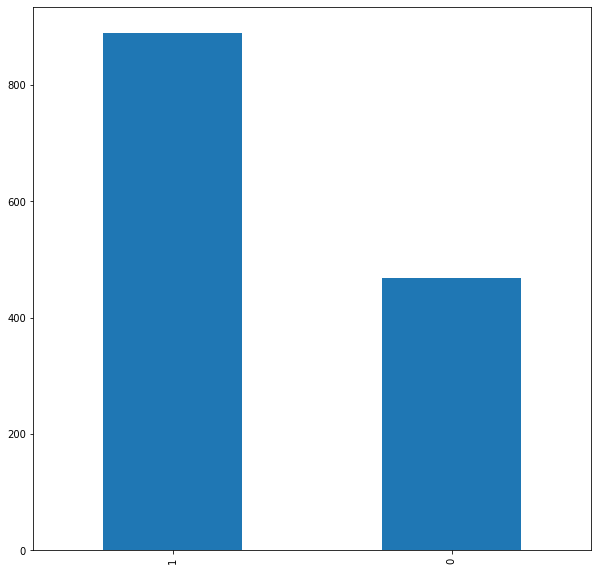

In [1656]:
plt.rcParams["figure.figsize"] = (10, 10) #set plot size
active_retired = Merged.groupby('IDs')['event'].max().value_counts()
display(active_retired)
active_retired.plot.bar()

Looking at the sum of grand tour starts, the average retired Tour de France starter between 1995 and 2019 started at `9.4` grand tours. Interestingly it seems, that only a few riders are able to take the start at more than 20 grand tours during their career.  

count    890.000000
mean       9.423596
std        5.876428
min        1.000000
25%        5.000000
50%        9.000000
75%       13.000000
max       34.000000
Name: Starts GT, dtype: float64

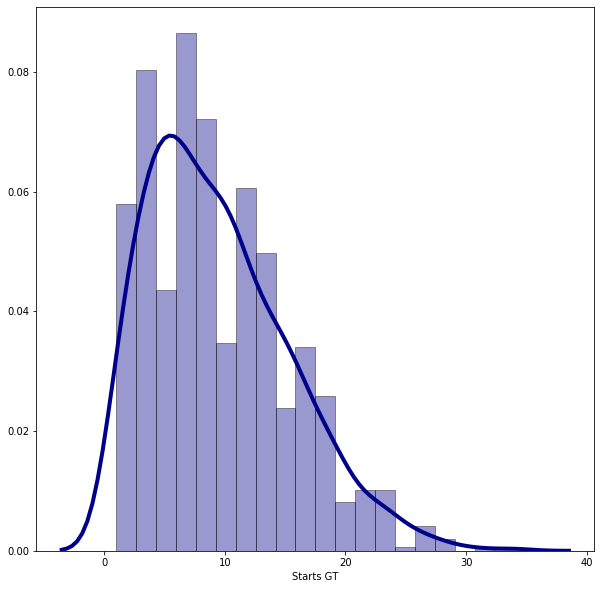

In [1657]:
gt_starts = Merged[Merged['UntilEvent'] != -99].groupby('IDs')['Starts GT'].sum()
display(gt_starts.describe())
# Density Plot and Histogram of sum of GT starts
sns.distplot(gt_starts, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Looking at the career length of the retired riders, they have been active on average for `13.8` years. Note, that this also includes any results achieved in the U19 and U23 age category.

count    890.000000
mean      13.848315
std        4.164303
min        1.000000
25%       11.000000
50%       14.000000
75%       17.000000
max       25.000000
Name: CareerLength, dtype: float64

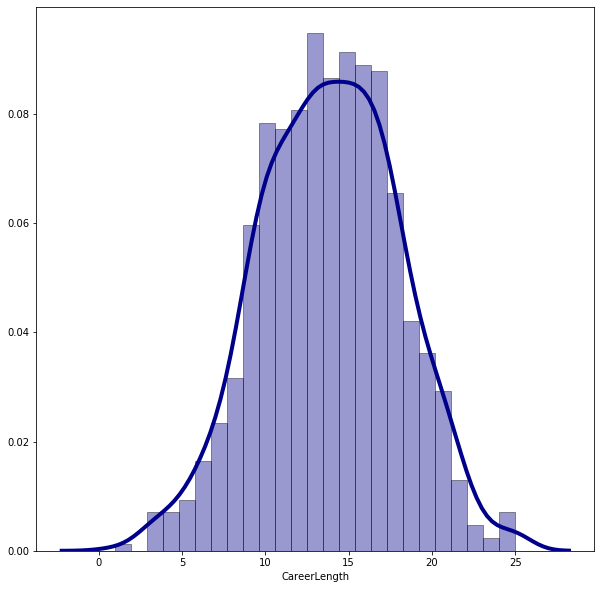

In [1658]:
c_length = Merged[Merged['UntilEvent'] != -99].groupby('IDs')['CareerLength'].max()
display(c_length.describe())
# Density Plot and Histogram of Career Length of rriders who already ended their career
sns.distplot(c_length, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            bins = 25)

How old are Tour de France riders when they retire? For the retired starters between 1995 and 2019 this was on average when being `34.5`years old.

count    890.000000
mean      34.474213
std        3.684208
min       23.570000
25%       31.985000
50%       34.475000
75%       37.042500
max       47.980000
Name: Age, dtype: float64

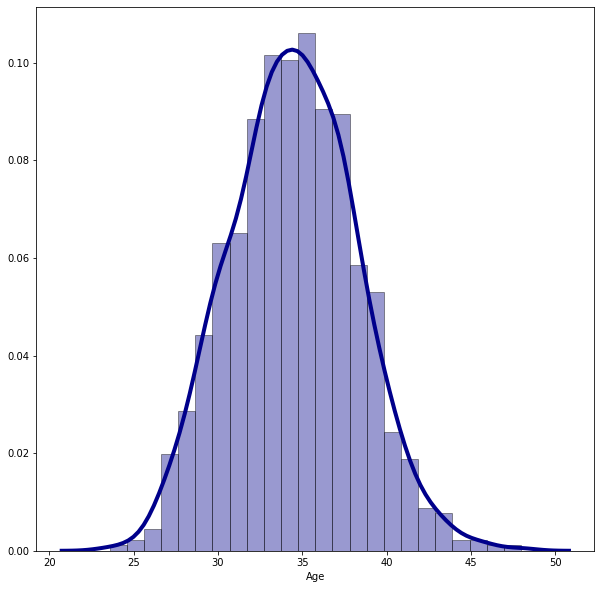

In [1659]:
age_end = Merged[Merged['UntilEvent'] != -99].groupby('IDs')['Age'].max()
display(age_end.describe())
# Density Plot and Histogram of age when riders ended their career
sns.distplot(age_end, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

The correlation heatmap below indicates a relationship between the target variable `UntilEvent` and the cumulative count of years ridden at the different levels, but also the yearly kilometers raced as well as the number of racedays.  

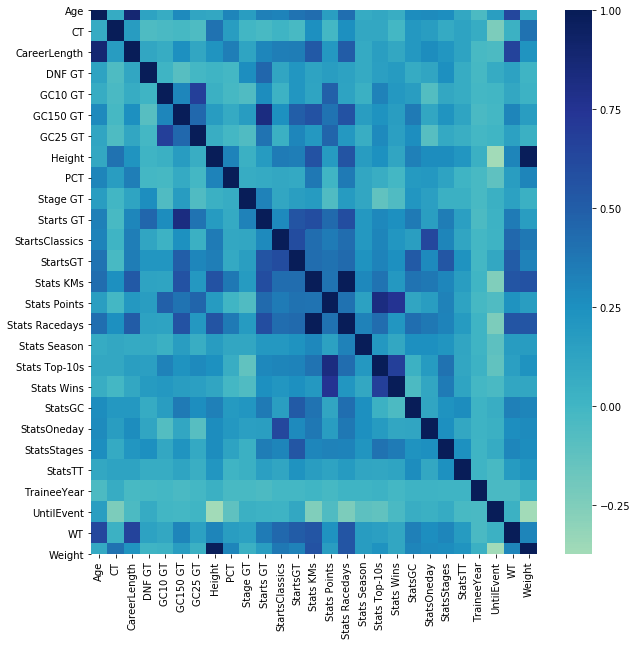

In [1663]:
sns.heatmap(Merged[Merged.columns.difference(['Season', 'IDs', 'start', 'stop', 'event'])].corr(),
            cmap="YlGnBu", center=0)

Exporting the data as a pickle file.  In the next notebook the data is feed into a neural network with Long-Short-Term-Memory (LSTM) cells in order to determine the years left of a riders career.

In [1571]:
import pickle
sys.setrecursionlimit(100000)
Merged.to_pickle('CleanData.pkl')